# Calculate time averages of data for calc. of Ri
## calculation of mean values of one week in march 2010
b, dbdx, dbdy
w, wb, w'b'

one fix of vertical velocity timestep 85 was broken and recalculated on levante

discoveries using dask:
* by setting processes and cores in slurmCluster memory per cores and worker can be choosen. However: WHat would be a good configuration?
* there are new configuration settings to avoid spill to disk, which improved by reducing the data spilled to disk but does not avoid it.
* scaling does seem to reduce compute time significantly


get cluster

In [1]:
#cluster
import dask
import datetime
import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
#from distributed.utils import tmpfile
#dask.config.set({"distributed.comm.timeouts.tcp": "50s"})

/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
!echo $HOSTNAME
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'compute' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "256GiB" # Max memory per node that is going to be used - this depends on the partition #for averaging max=256
cores = 16 # Max number of cores per task that are reserved - also partition dependend
processes = 16 #number of workers
walltime = '08:00:00' # Walltime - also partition dependent

l20100.atos.local


In [3]:
#calculate memory per worker and core
mem =256
memory_per_worker = mem/processes
memory_per_core = memory_per_worker/(cores/processes)
print('memory_per_worker =', memory_per_worker)
print('memory_per_core =', memory_per_core)

memory_per_worker = 16.0
memory_per_core = 16.0



#### no real improvement by scaling
on the edge with 50gib (at the ende of averaging) spill to disk, limit seems to be 16gib so half of memory per core
memory = "256GiB" # Max memory per node that is going to be used - this depends on the partition #for averaging max=256
* cores = 24 # Max number of cores per task that are reserved - also partition dependend
* processes = 8 #number of workers
* CPU times: user 2min 57s, sys: 49.9 s, total: 3min 46s
* Wall time: 16min 45s

* scale = 2
* cores=16
* processes=16
* CPU times: user 4min 18s, sys: 7.51 s, total: 4min 25s
* Wall time: 14min 15s


def disable_spill():
    from distributed import get_worker
    worker = get_worker()
    worker.memory_spill_fraction = 1.0

In [4]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       processes=processes,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [5]:
dask_tmp_dir.name

'/scratch/m/m300878/PostProcr5817bb4'

In [6]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=16
#SBATCH --mem=256G
#SBATCH -t 08:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/m/m300878/PostProcr5817bb4
#SBATCH --begin=now
#SBATCH --output=/scratch/m/m300878/PostProcr5817bb4/LOG_cluster.%j.o

/home/m/m300878/miniconda3/envs/pyicon_py39/bin/python -m distributed.cli.dask_worker tcp://136.172.115.43:42469 --nthreads 1 --nprocs 16 --memory-limit 16.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/m/m300878/PostProcr5817bb4 --interface ib0 --protocol tcp://



In [7]:
cluster.scale(jobs=2)
cluster

In [8]:
# try number 1 avoid spill to disk - seems not to arrive at client
dask.config.set({'distributed.worker.memory.spill': False})
dask.config.set({'distributed.worker.memory.target': False})

In [9]:
dask.config.get('distributed.worker')

{'blocked-handlers': [],
 'multiprocessing-method': 'spawn',
 'use-file-locking': True,
 'connections': {'outgoing': 50, 'incoming': 10},
 'preload': [],
 'preload-argv': [],
 'daemon': True,
 'validate': False,
 'resources': {},
 'lifetime': {'duration': None, 'stagger': '0 seconds', 'restart': False},
 'profile': {'interval': '10ms', 'cycle': '1000ms', 'low-level': False},
 'memory': {'recent-to-old-time': '30s',
  'rebalance': {'measure': 'optimistic',
   'sender-min': 0.3,
   'recipient-max': 0.6,
   'sender-recipient-gap': 0.1},
  'target': False,
  'spill': False,
  'pause': 0.8,
  'terminate': 0.95,
  'max-spill': False},
 'http': {'routes': ['distributed.http.worker.prometheus',
   'distributed.http.health',
   'distributed.http.statics']}}

In [123]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            933726   compute PostProc  m300878  R    1:08:31      1 l40104
            933727   compute PostProc  m300878  R    1:08:31      1 l40149
            933709   compute interact  m300878  R    1:11:00      1 l20100


In [11]:
! scancel 756796

In [11]:
! squeue --start -j 791150

             JOBID PARTITION     NAME     USER ST          START_TIME  NODES SCHEDNODES           NODELIST(REASON)
            791150   compute PostProc  m300878 PD 2022-06-15T12:28:31      1 l40250               (Priority)


In [130]:
cluster.close()
client.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [124]:
client = Client(cluster)
client

<Client: 'tcp://136.172.115.43:42469' processes=32 threads=32, memory=512.00 GiB>

In [13]:
#changing present config file, in other system config it is here ~/.config/dask/my_config_settings.yaml
def disable_spill():
    dask.config.set({'distributed.worker.memory.target': False, 
    'distributed.worker.memory.spill': False, 
    'distributed.worker.memory.pause':0.95,
    'distributed.worker.memory.terminate':0.96}
    )
    print(dask.config.config)
    
client.register_worker_callbacks(setup=disable_spill)

{'tcp://136.172.120.119:32793': {'status': 'OK'},
 'tcp://136.172.120.119:35187': {'status': 'OK'},
 'tcp://136.172.120.119:35643': {'status': 'OK'},
 'tcp://136.172.120.119:36297': {'status': 'OK'},
 'tcp://136.172.120.119:36325': {'status': 'OK'},
 'tcp://136.172.120.119:38695': {'status': 'OK'},
 'tcp://136.172.120.119:39733': {'status': 'OK'},
 'tcp://136.172.120.119:40857': {'status': 'OK'},
 'tcp://136.172.120.119:40977': {'status': 'OK'},
 'tcp://136.172.120.119:41033': {'status': 'OK'},
 'tcp://136.172.120.119:41533': {'status': 'OK'},
 'tcp://136.172.120.119:41541': {'status': 'OK'},
 'tcp://136.172.120.119:42821': {'status': 'OK'},
 'tcp://136.172.120.119:44061': {'status': 'OK'},
 'tcp://136.172.120.119:44471': {'status': 'OK'},
 'tcp://136.172.120.119:46231': {'status': 'OK'},
 'tcp://136.172.120.164:33957': {'status': 'OK'},
 'tcp://136.172.120.164:34101': {'status': 'OK'},
 'tcp://136.172.120.164:34199': {'status': 'OK'},
 'tcp://136.172.120.164:35185': {'status': 'OK'},


In [14]:
%%capture
def get_config():
     return dask.config.config
     
client.run(get_config)

# Start calc averages

In [15]:
%%capture
import sys
import glob, os
os.chdir('/home/m/m300878/submesoscaletelescope/notebooks/may22/')
sys.path.insert(1, '../')
from icon_smt_levels import dzw, dzt, depthc, depthi
sys.path.insert(1, '/home/m/m300878/submesoscaletelescope/run_batch_job/model_evaluation/')
#from eval_funcs import *
import eval_funcs as eva

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import pyicon as pyic

In [16]:
import gsw
from icon_smt_levels import dzw, dzt, depthc, depthi

In [17]:
lon_reg = [-65, -60]
lat_reg = [38.75, 41.25]
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'


# average over N2

In [20]:
n = eva.load_smt_N2()
n

<xarray.Dataset>
Dimensions:  (time: 85, depthi: 113, ncells: 59799625)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
Dimensions without coordinates: ncells
Data variables:
    N2       (time, depthi, ncells) float32 dask.array<chunksize=(1, 1, 59799625), meta=np.ndarray>

In [ ]:
n_t_ave = n.mean(dim='time') #here. average over one week
n_t_ave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
n_t_ave.attrs["time steps"] = "85"
n_t_ave

In [45]:
n_t_ave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/n2.nc')

### a glance

In [37]:
lon_reg = [-72.5, -55]
lat_reg = [32, 42]
clim= -0.00001, 0.00001
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
#lon, lat, data = pyic.interp_to_rectgrid(n2_tave.N2.isel(depthi=5), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim,  cmap='PiYG')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

In [34]:
clim= -0.00001, 0.00001
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
lon, lat, data = pyic.interp_to_rectgrid(n_t_ave.N2.isel(depthi=5), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim,  cmap='PiYG')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

#data_n2 = data

## instantaneous image for comparison

In [32]:
clim= -0.00001, 0.00001
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
lon, lat, data = pyic.interp_to_rectgrid(n.N2.isel(depthi=5).isel(time=10), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim,  cmap='PiYG')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

#data_n2 = data

# average of w

In [138]:
ds_w = eva.load_smt_w()
ds_w

<xarray.Dataset>
Dimensions:  (depthi: 113, time: 85, ncells: 59799625)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
Dimensions without coordinates: ncells
Data variables:
    w        (time, depthi, ncells) float32 dask.array<chunksize=(1, 1, 59799625), meta=np.ndarray>

In [141]:
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
clim= 5e-4
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
#lon, lat, data = pyic.interp_to_rectgrid(ds_w.w.isel(depthi=3, time=84), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, clim=clim,  rasterized=False, cmap='RdYlBu')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

In [142]:
# average
ds_w_tave = ds_w
ds_w_tave = ds_w_tave.mean(dim='time')
ds_w_tave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
ds_w_tave.attrs["time steps"] = "85"
ds_w_tave

<xarray.Dataset>
Dimensions:  (depthi: 113, ncells: 59799625)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Data variables:
    w        (depthi, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>

In [143]:
%%time
#ds_w_tave = ds_w_tave.compute()
ds_w_tave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/w.nc')

CPU times: user 4min 18s, sys: 7.51 s, total: 4min 25s
Wall time: 14min 15s


### a glance

In [23]:
lon_reg = [-72.5, -55]
lat_reg = [32, 42]
lon_reg = [-65, -60]
lat_reg = [38.75, 41.25]

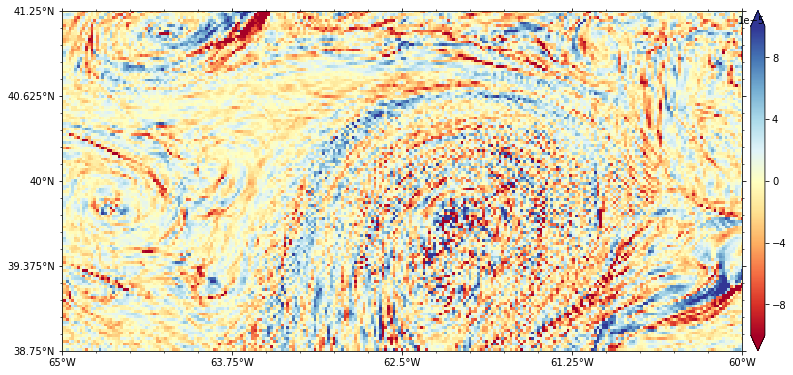

In [89]:
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
clim= 1e-4
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
#lon, lat, data = pyic.interp_to_rectgrid(ds_w_tave, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, clim=clim,  rasterized=False, cmap='RdYlBu')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

# average of b

## mean of b

In [98]:
ds_b = eva.load_smt_b()
ds_b = ds_b.b
ds_b

<xarray.DataArray 'b' (time: 85, depthi: 113, ncells: 59799625)>
dask.array<concatenate, shape=(85, 113, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
Dimensions without coordinates: ncells

In [100]:
ds_b_tave = ds_b.mean(dim='time')
ds_b_tave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
ds_b_tave.attrs["time steps"] = "85"
ds_b_tave

<xarray.DataArray 'b' (depthi: 113, ncells: 59799625)>
dask.array<mean_agg-aggregate, shape=(113, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Attributes:
    time averaged:  2010-03-15T21 - 2010-03-22T21
    time steps:     85

In [101]:
%%time
ds_b_tave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/b_mean.nc')


CPU times: user 5min 9s, sys: 8.97 s, total: 5min 18s
Wall time: 17min 8s


## mean of dbdx

In [18]:
b = eva.load_smt_b()
b.dbdx

<xarray.DataArray 'dbdx' (time: 85, depthi: 113, ncells: 59799625)>
dask.array<concatenate, shape=(85, 113, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
Dimensions without coordinates: ncells

In [28]:
ds_dbdx_tave = b.dbdx.mean(dim='time')
ds_dbdx_tave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
ds_dbdx_tave.attrs["time steps"] = "85"
ds_dbdx_tave

<xarray.DataArray 'dbdx' (depthi: 113, ncells: 59799625)>
dask.array<mean_agg-aggregate, shape=(113, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Attributes:
    time averaged:  2010-03-15T21 - 2010-03-22T21
    time steps:     85

ds_dbdx_tave = ds_dbdx_tave.isel(depthi=5)
ds_dbdx_tave

In [ ]:
%%time
#ds_dbdx_tave = ds_dbdx_tave.compute()
ds_dbdx_tave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/dbdx.nc')


### a glance

In [30]:
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
# plot region
lon_reg = [-72.5, -55]
lat_reg = [32, 42]
clim= 0, -1e-7
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
lon, lat, data = pyic.interp_to_rectgrid(ds_dbdx_tave.isel(depthi=5), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim, cmap='RdPu_r')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)
    

### and dbdy

In [19]:
ds_dbdy_tave = b.dbdy.mean(dim='time')
ds_dbdy_tave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
ds_dbdy_tave.attrs["time steps"] = "85"
ds_dbdy_tave

<xarray.DataArray 'dbdy' (depthi: 113, ncells: 59799625)>
dask.array<mean_agg-aggregate, shape=(113, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Attributes:
    time averaged:  2010-03-15T21 - 2010-03-22T21
    time steps:     85

In [20]:
%%time
#ds_dbdy_tave = ds_dbdy_tave.compute()
ds_dbdy_tave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/dbdy.nc')



CPU times: user 2min 52s, sys: 5.95 s, total: 2min 58s
Wall time: 11min 38s


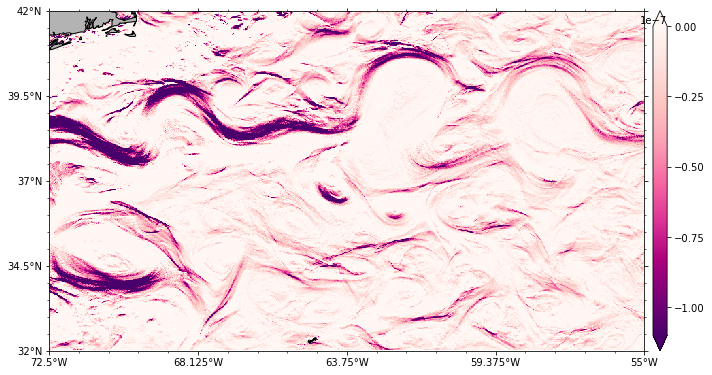

In [22]:
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
# plot region
lon_reg = [-72.5, -55]
lat_reg = [32, 42]
clim= 0, -1e-7
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
lon, lat, data = pyic.interp_to_rectgrid(ds_dbdy_tave.isel(depthi=5), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim, cmap='RdPu_r')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)
    

# averages of products

## wb mean

In [144]:
ds_b = eva.load_smt_b()
ds_b = ds_b.b
ds_b

<xarray.DataArray 'b' (time: 85, depthi: 113, ncells: 59799625)>
dask.array<concatenate, shape=(85, 113, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
Dimensions without coordinates: ncells

In [147]:
ds_w = eva.load_smt_w()
ds_w = ds_w.w

In [155]:
wb = ds_w * ds_b
wb

<xarray.DataArray (time: 85, depthi: 113, ncells: 59799625)>
dask.array<mul, shape=(85, 113, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
Dimensions without coordinates: ncells

In [156]:
ds_wb_tave = wb.mean(dim='time')
ds_wb_tave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
ds_wb_tave.attrs["time steps"] = "85"
ds_wb_tave

<xarray.DataArray (depthi: 113, ncells: 59799625)>
dask.array<mean_agg-aggregate, shape=(113, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Attributes:
    time averaged:  2010-03-15T21 - 2010-03-22T21
    time steps:     85

In [157]:
ds_wb_tave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb_mean.nc')



## w'b' mean

load

In [19]:
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb_mean.nc'
ds_wb = xr.open_dataset(path_data, chunks=dict(depthi=1))
ds_wb = ds_wb.rename(__xarray_dataarray_variable__='wb_mean')
ds_wb

<xarray.Dataset>
Dimensions:  (depthi: 113, ncells: 59799625)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Data variables:
    wb_mean  (depthi, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>

In [20]:
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/w.nc'
ds_w = xr.open_dataset(path_data, chunks=dict(depthi=1))
ds_w

<xarray.Dataset>
Dimensions:  (depthi: 113, ncells: 59799625)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Data variables:
    w        (depthi, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>

In [21]:
path_data = '/work/mh0033/m300878/parameterization/time_averages/one_week_march/b_mean.nc'
ds_b = xr.open_dataset(path_data, chunks=dict(depthi=1))
ds_b

<xarray.Dataset>
Dimensions:  (depthi: 113, ncells: 59799625)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells
Data variables:
    b        (depthi, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>

In [23]:
wb_prime = ds_wb.wb_mean - ds_w.w * ds_b.b
wb_prime

<xarray.DataArray (depthi: 113, ncells: 59799625)>
dask.array<sub, shape=(113, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
Dimensions without coordinates: ncells

In [24]:
wb_prime.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb_prime.nc')

## T, S

In [104]:
import importlib

In [105]:
importlib.reload(eva)

Load my smt functions


<module 'eval_funcs' from '/home/m/m300878/submesoscaletelescope/run_batch_job/model_evaluation/eval_funcs.py'>

In [117]:
t = eva.load_smt_T()
t

<xarray.DataArray 'T001_sp' (depthc: 112, time: 984, ncells: 59799625)>
dask.array<concatenate, shape=(112, 984, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    standard_name:                temperature at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

### select same timewindow

In [109]:
t.time[790]

<xarray.DataArray 'time' ()>
array('2010-03-15T21:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-03-15T21:00:00

In [118]:
t.time[875] #count +1

<xarray.DataArray 'time' ()>
array('2010-03-22T23:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-03-22T23:00:00

In [119]:
t = t.isel(time=slice(790, 875))
t

<xarray.DataArray 'T001_sp' (depthc: 112, time: 85, ncells: 59799625)>
dask.array<getitem, shape=(112, 85, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    standard_name:                temperature at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [121]:
t_ave = t.mean(dim='time') #here. average over one week
t_ave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
t_ave.attrs["time steps"] = "85"
t_ave

<xarray.DataArray 'T001_sp' (depthc: 112, ncells: 59799625)>
dask.array<mean_agg-aggregate, shape=(112, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    time averaged:  2010-03-15T21 - 2010-03-22T21
    time steps:     85

In [125]:
t_ave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/t.nc')

In [126]:
s = eva.load_smt_S()
s

<xarray.DataArray 'S001_sp' (depthc: 112, time: 984, ncells: 59799625)>
dask.array<concatenate, shape=(112, 984, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    standard_name:                salinity at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [127]:
s = s.isel(time=slice(790, 875))
s

<xarray.DataArray 'S001_sp' (depthc: 112, time: 85, ncells: 59799625)>
dask.array<getitem, shape=(112, 85, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    standard_name:                salinity at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [128]:
s_ave = s.mean(dim='time') #here. average over one week
s_ave.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
s_ave.attrs["time steps"] = "85"
s_ave

<xarray.DataArray 'S001_sp' (depthc: 112, ncells: 59799625)>
dask.array<mean_agg-aggregate, shape=(112, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    time averaged:  2010-03-15T21 - 2010-03-22T21
    time steps:     85

In [129]:
%%time
s_ave.to_netcdf('/work/mh0033/m300878/parameterization/time_averages/one_week_march/s.nc')

CPU times: user 1min 49s, sys: 2.97 s, total: 1min 52s
Wall time: 11min 28s
